In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD

import pickle
import igraph

In [2]:
m_graph = pickle.load(open('./data/icwsm_polarization/mention_igraph.pickle', "rb"))
r_graph = pickle.load(open('./data/icwsm_polarization/retweet_igraph.pickle', "rb"))

In [3]:
all_graph = pickle.load(open('./data/icwsm_polarization/all_igraph.pickle', "rb"))

In [4]:
r_graph.edge_attributes()

['tags', 'type', 'urls', 'time']

In [5]:
r_graph.get_edgelist()[0:10]

[(12464, 7349),
 (6820, 12569),
 (4336, 15967),
 (16397, 5927),
 (8829, 13851),
 (17673, 5153),
 (5467, 3944),
 (9864, 2813),
 (15781, 5425),
 (1195, 6940)]

In [6]:
r_graph.es["tags"][0:10]

[['#tcot', '#tlot'],
 ['#p2', '#progca', '#casen'],
 ['#dems', '#ocra', '#p2', '#s'],
 ['#tcot'],
 ['#teaparty', '#tcot', '#alaska', '#ak'],
 ['#desen', '#tcot', '#teaparty'],
 ['#cuba', '#obama', '#eeuu'],
 ['#ocra', '#tcot'],
 ['#dems'],
 ['#tcot', '#teaparty', '#sgp']]

In [7]:
def reverse_igraph_edges(graph):
    edge_attributes = graph.edge_attributes()
    attributes_dict = {attr:r_graph.es[attr] for attr in edge_attributes}
    
    reversed_edges = [tuple(reversed(edge)) for edge  in graph.get_edgelist()]
    
    graph.es.delete()
    
    graph.add_edges(reversed_edges)
    
    for attr in edge_attributes:
        r_graph.es[attr] = attributes_dict[attr]


In [8]:
reverse_igraph_edges(r_graph)

In [9]:
r_graph.get_edgelist()[0:10]

[(7349, 12464),
 (12569, 6820),
 (15967, 4336),
 (5927, 16397),
 (13851, 8829),
 (5153, 17673),
 (3944, 5467),
 (2813, 9864),
 (5425, 15781),
 (6940, 1195)]

In [10]:
r_graph.es["tags"][0:10]

[['#tcot', '#tlot'],
 ['#p2', '#progca', '#casen'],
 ['#dems', '#ocra', '#p2', '#s'],
 ['#tcot'],
 ['#teaparty', '#tcot', '#alaska', '#ak'],
 ['#desen', '#tcot', '#teaparty'],
 ['#cuba', '#obama', '#eeuu'],
 ['#ocra', '#tcot'],
 ['#dems'],
 ['#tcot', '#teaparty', '#sgp']]

In [23]:
m_layout = m_graph.layout("large")

In [ ]:
r_layout=r_graph.layout("large")

In [5]:
m_graph.vs["size"]=4
m_graph.es["arrow_size"]=0.3
m_graph.es["width"]=0.5
m_graph.es["color"]="#b3b3b3"
color_dict = {"left": "#0015bc", "right": "#e91d0e", "-": "grey"}
m_graph.vs["color"] = [color_dict[cluster] for cluster in m_graph.vs["cluster"]]
m_out = igraph.plot(m_graph, layout=m_layout)

m_out.save("mention_network.png")

In [76]:
r_graph.vs["size"]=4
r_graph.es["arrow_size"]=0.3
r_graph.es["width"]=0.5
r_graph.es["color"]="#b3b3b3"
color_dict = {"left": "#0015bc", "right": "#e91d0e", "-": "grey"}
r_graph.vs["color"] = [color_dict[cluster] for cluster in r_graph.vs["cluster"]]
r_out = igraph.plot(r_graph, layout=r_layout)

r_out.save("retweet_network.png")

In [11]:
def plot_edge_distribution(ax, graph, mode, g_type):
    if (mode=="out" or mode=="in"):
        x = list(range(0, graph.maxdegree(mode=mode) + 1))
        y =[graph.degree(mode=mode).count(i) for i in x]

        ax.loglog(x, y, "k.")
        ax.set_xlabel("number of {}".format(g_type))
        ax.set_ylabel("number of users")

In [12]:
width = 12
height = width / 1.618

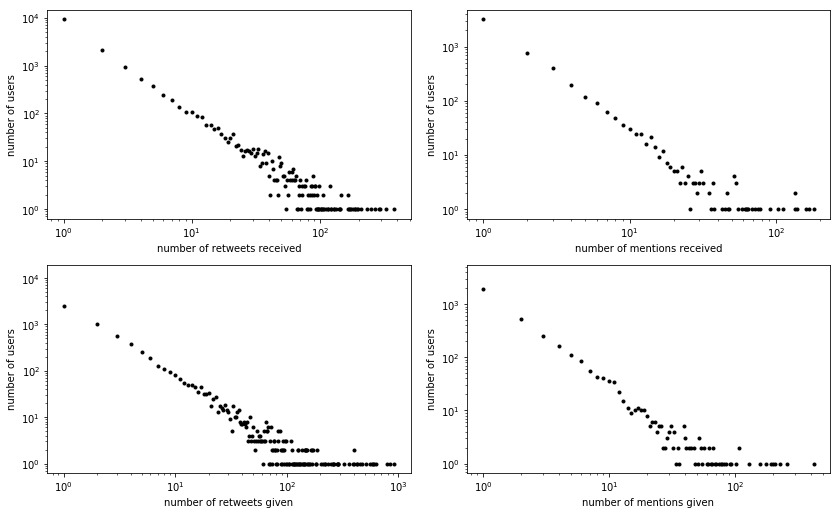

In [13]:
fig, ax = plt.subplots(2,2, figsize=(width, height))
fig.tight_layout(pad=2.5)
plot_edge_distribution(ax[0, 0], r_graph, "out", "retweets received")
plot_edge_distribution(ax[1, 0], r_graph, "in", "retweets given")
plot_edge_distribution(ax[0, 1], m_graph, "out", "mentions received")
plot_edge_distribution(ax[1, 1], m_graph, "in", "mentions given")
fig.savefig("edge_distributions.png", quality=95)

In [ ]:
# Build vocabulary vector
# go through all of the edges in the edgelist. If a certain tag is used, then increment the entry in the tag.
# will need a dictionary that maps hashtags to indices in the vocabulary vector
# then going through the entire edgelist again, will need to look at the source (this is the actor)
# and will need to look at the tags associated with that tweet
# then going through each tag, find its appropriate index in the vector, and increment it for that actor


In [14]:
def get_tag_vocab(graph):
    tag2index = {}
    index = 0
    for taglist in graph.es["tags"]:
        for tag in taglist:
            if tag not in tag2index:
                tag2index[tag] = index
                index = index + 1

    return tag2index


In [15]:
vocab = get_tag_vocab(all_graph)

In [16]:
def get_bag_of_tags(graph, vocab):
    n_nodes = len(graph.vs)
    n_vocab = len(vocab)
    bag_of_tags = np.zeros((n_nodes, n_vocab))

    for i in range(len(graph.get_edgelist())):
        node_index = graph.es[i].source
        for tag in graph.es[i]['tags']:
            tag_index = vocab[tag]
            bag_of_tags[node_index][tag_index] += 1
            
    return bag_of_tags

In [17]:
bag_of_tags = get_bag_of_tags(all_graph, vocab)

In [18]:
# put into a pandas and perform PCA
tags_df = pd.DataFrame(data=bag_of_tags, columns=vocab.keys())

In [19]:
tags_df.head()

,#tcot,#memories4nov,#ocra,#dadt,#alaska,#ak,#aksen,#teaparty,#gop,#justsayin,...,#ronjohnson,#fearmongers,#opp,#joemilelr,#socialnetwork,#wilmd,#winwin7,#maloney,#hold,#camdengop
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
norm_tags = pd.DataFrame(data=StandardScaler().fit_transform(tags_df), columns=vocab.keys())

In [21]:
norm_tags.head()

,#tcot,#memories4nov,#ocra,#dadt,#alaska,#ak,#aksen,#teaparty,#gop,#justsayin,...,#ronjohnson,#fearmongers,#opp,#joemilelr,#socialnetwork,#wilmd,#winwin7,#maloney,#hold,#camdengop
0,-0.121762,-0.008279,-0.038114,-0.027791,-0.013573,-0.013942,-0.045922,-0.103284,-0.064314,-0.03639,...,-0.006681,-0.006681,-0.006681,-0.006681,-0.006681,-0.006681,-0.006681,-0.006681,-0.006681,-0.006681
1,0.023577,-0.008279,-0.038114,-0.027791,-0.013573,-0.013942,-0.045922,0.083125,0.140629,-0.03639,...,-0.006681,-0.006681,-0.006681,-0.006681,-0.006681,-0.006681,-0.006681,-0.006681,-0.006681,-0.006681
2,-0.121762,-0.008279,-0.038114,-0.027791,-0.013573,-0.013942,-0.045922,-0.103284,-0.064314,-0.03639,...,-0.006681,-0.006681,-0.006681,-0.006681,-0.006681,-0.006681,-0.006681,-0.006681,-0.006681,-0.006681
3,-0.121762,-0.008279,-0.038114,-0.027791,-0.013573,-0.013942,-0.045922,-0.103284,-0.064314,-0.03639,...,-0.006681,-0.006681,-0.006681,-0.006681,-0.006681,-0.006681,-0.006681,-0.006681,-0.006681,-0.006681
4,-0.121762,-0.008279,-0.038114,-0.027791,-0.013573,-0.013942,-0.045922,-0.103284,-0.064314,-0.03639,...,-0.006681,-0.006681,-0.006681,-0.006681,-0.006681,-0.006681,-0.006681,-0.006681,-0.006681,-0.006681


In [22]:
# Perform PCA
pca = TruncatedSVD(n_components=2)
principal_tags = pd.DataFrame(data=pca.fit_transform(norm_tags), columns=["PC1", "PC2"])

In [23]:
principal_tags.head()

,PC1,PC2
0,-0.155335,-0.170627
1,-0.106978,-0.054073
2,-0.102747,-0.140105
3,-0.155335,-0.170627
4,-0.146267,-0.157752


In [24]:
# Create full dataframe
label = pd.DataFrame(data=all_graph.vs["cluster"], columns=["label"])
label.head()

,label
0,right
1,right
2,left
3,left
4,-


In [25]:
principal_tags_full = pd.concat([principal_tags, label], axis=1)
principal_tags_full.head()

,PC1,PC2,label
0,-0.155335,-0.170627,right
1,-0.106978,-0.054073,right
2,-0.102747,-0.140105,left
3,-0.155335,-0.170627,left
4,-0.146267,-0.157752,-


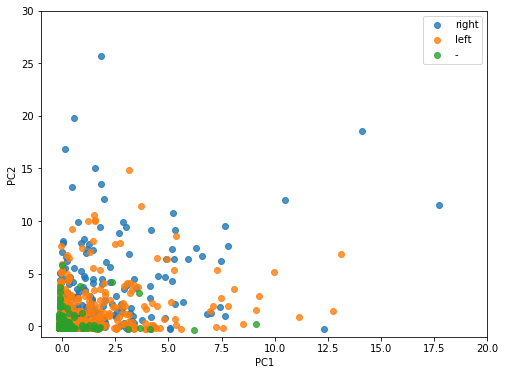

In [27]:
# plot with given labels
fig = plt.figure(figsize=(8,6))
ax = fig.gca()
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
l = principal_tags_full["label"]
label_list = l.unique()
for target in label_list:
    target_indices = (l == target)
    ax.scatter(principal_tags_full.loc[target_indices, 'PC1']
              , principal_tags_full.loc[target_indices, 'PC2']
              , alpha=0.8)
    ax.legend(label_list, loc='best')
    ax.set_xlim(-1,20)
    ax.set_ylim(-1,30)

array(['right', 'left', '-'], dtype=object)